In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import optimize
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [31]:
# ===============================
# 1) CARGA Y LIMPIEZA
# ===============================
datos = pd.read_excel('/content/elecciones 2025.xlsx')
datos.columns = datos.columns.str.strip()

for col in ["NombrePais", "NombreDepartamento", "NombreProvincia",
            "NombreMunicipio", "NombreLocalidad", "NombreRecinto"]:
    if col in datos.columns:
        datos[col] = datos[col].astype(str).str.strip()

# -------------------------------
# Columnas de votos (para Y)
# -------------------------------
votos_cols = [
    "AP", "LYP ADN", "APB SUMATE", "LIBRE", "FP",
    "MAS-IPSP", "MORENA", "UNIDAD", "PDC",
    "VotoBlanco", "VotoNuloDirecto", "VotoNuloDeclinacion"
]
# Verifica que existan
votos_cols = [c for c in votos_cols if c in datos.columns]

# ===============================
# 2) TARGET MULTICLASE (Y)
# ===============================
partido_a_codigo = {partido: idx for idx, partido in enumerate(votos_cols)}
codigo_a_partido = {v: k for k, v in partido_a_codigo.items()}
Y = datos[votos_cols].idxmax(axis=1).map(partido_a_codigo).values  # shape (m,)

# ===============================
# 3) FEATURES (X) n > 10
#    (NO usamos columnas de votos para evitar fuga de información)
# ===============================
# Usamos códigos y numéricos del dataset + label-encode de nombres (no de votos)
le_pais  = LabelEncoder().fit(datos["NombrePais"])
le_depto = LabelEncoder().fit(datos["NombreDepartamento"])
le_prov  = LabelEncoder().fit(datos["NombreProvincia"])
le_muni  = LabelEncoder().fit(datos["NombreMunicipio"])
le_loc   = LabelEncoder().fit(datos["NombreLocalidad"])
le_rec   = LabelEncoder().fit(datos["NombreRecinto"])

datos["Pais"]          = le_pais.transform(datos["NombrePais"])
datos["Departamento"]  = le_depto.transform(datos["NombreDepartamento"])
datos["Provincia"]     = le_prov.transform(datos["NombreProvincia"])
datos["Municipio"]     = le_muni.transform(datos["NombreMunicipio"])
datos["Localidad"]     = le_loc.transform(datos["NombreLocalidad"])
datos["Recinto"]       = le_rec.transform(datos["NombreRecinto"])

# Selección de >10 features (todas numéricas)
feat_cols = []
for c in [
    "CodigoPais","CodigoDepartamento","CodigoCircunscripcionU","CodigoCircunscripcionE",
    "CodigoProvincia","CodigoSeccion","CodigoLocalidad","CodigoRecinto",
    "NumeroMesa","InscritosHabilitados",
    "Pais","Departamento","Provincia","Municipio","Localidad","Recinto"
]:
    if c in datos.columns:
        feat_cols.append(c)

X = datos[feat_cols].values   # shape (m, n) con n > 10

print("Shape X:", X.shape, "| Shape Y:", Y.shape)
assert X.shape[0] == Y.shape[0]

# ===============================
# 4) SPLIT 80/20 (estratificado)
# ===============================
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.20, random_state=42, stratify=Y
)

Shape X: (69279, 16) | Shape Y: (69279,)


In [3]:
# ===============================
# 5) NORMALIZACIÓN (solo con TRAIN)
# ===============================
def featureNormalize(X):
    mu = np.mean(X, axis=0)
    sigma = np.std(X, axis=0)
    sigma[sigma == 0] = 1.0
    X_norm = (X - mu) / sigma
    return X_norm, mu, sigma

In [4]:
X_train_norm, mu, sigma = featureNormalize(X_train)
X_test_norm = (X_test - mu) / sigma

In [5]:
def sigmoid(z):
    return 1.0 / (1.0 + np.exp(-z))

In [6]:
def lrCostFunction(theta, X, y, lambda_):
    # X: (m, n+1) ya con bias; theta: (n+1,)
    m = y.size
    h = sigmoid(X.dot(theta))  # (m,)

    # Evitar log(0)
    eps = 1e-12
    h = np.clip(h, eps, 1 - eps)

    # Regularización sin theta0
    temp = theta.copy()
    temp[0] = 0.0

    J = (1.0/m) * ( - y.dot(np.log(h)) - (1 - y).dot(np.log(1 - h)) ) \
        + (lambda_/(2.0*m)) * np.sum(temp**2)

    grad = (1.0/m) * (X.T.dot(h - y)) + (lambda_/m) * temp
    return J, grad

In [18]:
# Entrenador OVA con historial de costo por clase
def OneVsAllOM(X, y, num_labels, lambda_, maxiter=1000):
    # X: (m, n) sin bias
    m, n = X.shape
    all_theta = np.zeros((num_labels, n + 1))
    cost_history = [[] for _ in range(num_labels)]  # historial por clase

    # Agrega bias a X
    Xb = np.concatenate([np.ones((m, 1)), X], axis=1)

    for c in range(num_labels):
        initial_theta = np.zeros(n + 1)

        # y binario para clase c
        y_c = (y == c).astype(int)

        # callback para guardar costo en cada iter
        def callbackF(th):
            J, _ = lrCostFunction(th, Xb, y_c, lambda_)
            cost_history[c].append(J)

        res = optimize.minimize(
            fun=lambda th, Xb_, y_, l_: lrCostFunction(th, Xb_, y_, l_)[0],
            x0=initial_theta,
            args=(Xb, y_c, lambda_),
            jac=lambda th, Xb_, y_, l_: lrCostFunction(th, Xb_, y_, l_)[1],
            method='L-BFGS-B',
            options={'maxiter': maxiter, 'disp': False},
            callback=callbackF
        )
        all_theta[c] = res.x

    return all_theta, cost_history

In [8]:
def predictOneVsAll(all_theta, X):
    m = X.shape[0]
    Xb = np.concatenate([np.ones((m,1)), X], axis=1)
    probs = sigmoid(Xb.dot(all_theta.T))  # (m, K)
    p = np.argmax(probs, axis=1)
    return p

In [26]:
# Número correcto de clases:
num_labels = len(votos_cols)   # ¡NO uses len(Y)!
lambda_ = 0.1
all_theta, cost_history = OneVsAllOM(X_train_norm, y_train, num_labels, lambda_, maxiter=500)


/tmp/ipython-input-1943851680.py:22: DeprecationWarning: scipy.optimize: The `disp` and `iprint` options of the L-BFGS-B solver are deprecated and will be removed in SciPy 1.18.0.
  res = optimize.minimize(


Precisión TRAIN: 52.32%
Precisión TEST : 51.72%

Reporte de clasificación (TEST):
              precision    recall  f1-score   support

           0      0.000     0.000     0.000        90
           1      0.000     0.000     0.000         3
           2      0.000     0.000     0.000       131
           3      0.498     0.633     0.558      3907
           4      0.000     0.000     0.000         4
           5      0.000     0.000     0.000        29
           7      0.426     0.226     0.295      1811
           8      0.545     0.603     0.573      4221
           9      0.307     0.060     0.101       712
          10      0.542     0.575     0.558      2947
          11      0.000     0.000     0.000         1

    accuracy                          0.517     13856
   macro avg      0.211     0.191     0.190     13856
weighted avg      0.494     0.517     0.494     13856



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


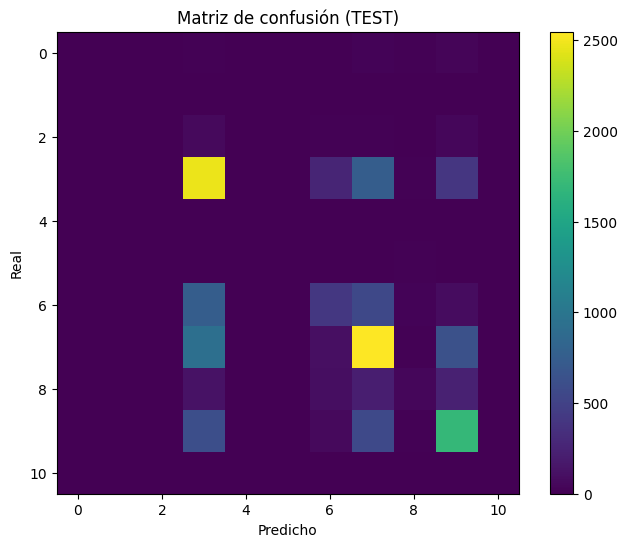

In [32]:
# ===============================
# 7) EVALUACIÓN
# ===============================
y_pred_train = predictOneVsAll(all_theta, X_train_norm)
y_pred_test  = predictOneVsAll(all_theta, X_test_norm)

acc_train = accuracy_score(y_train, y_pred_train)
acc_test  = accuracy_score(y_test, y_pred_test)

print(f"Precisión TRAIN: {acc_train*100:.2f}%")
print(f"Precisión TEST : {acc_test*100:.2f}%")

print("\nReporte de clasificación (TEST):")
print(classification_report(y_test, y_pred_test, digits=3))

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred_test)
plt.figure(figsize=(8,6))
plt.imshow(cm, interpolation='nearest')
plt.title("Matriz de confusión (TEST)")
plt.xlabel("Predicho")
plt.ylabel("Real")
plt.colorbar()
plt.show()


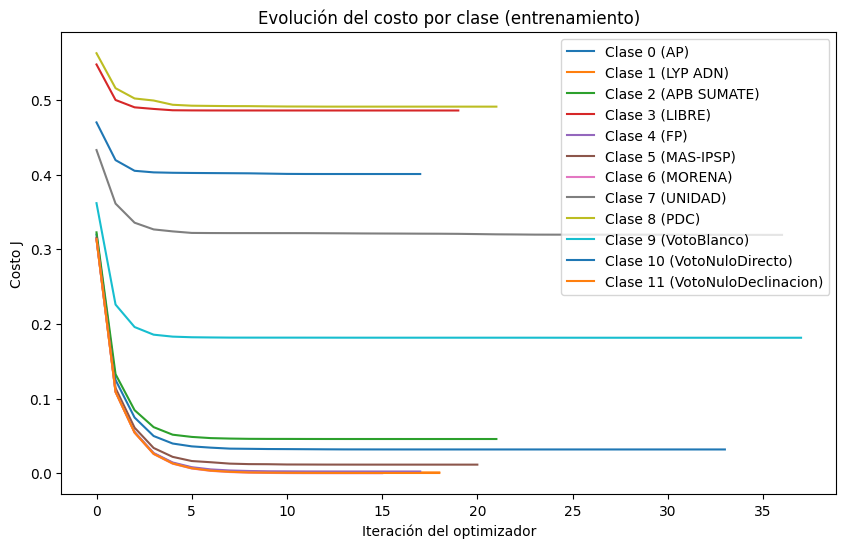

In [28]:
# ===============================
# 8) GRÁFICAS DE COSTO
# ===============================
# Costos por clase durante el entrenamiento (mostramos las primeras 4 para no saturar)
plt.figure(figsize=(10,6))
for c in range(len(cost_history)):
    if len(cost_history[c]) > 0:
        plt.plot(cost_history[c], label=f"Clase {c} ({codigo_a_partido.get(c,'?')})")
plt.xlabel("Iteración del optimizador")
plt.ylabel("Costo J")
plt.title("Evolución del costo por clase (entrenamiento)")
plt.legend()
plt.show()

In [29]:
# ===============================
# 9) PREDICCIÓN DE NUEVO EJEMPLO
#    (aplica los mismos encoders y normalización)
# ===============================
paiz = "BOLIVIA"
departamento = "Potosí"
provincia = "Tomás Frías"
inscritos = 21000

paiz_code = le_pais.transform([paiz])[0]
dept_code = le_depto.transform([departamento])[0]
prov_code = le_prov.transform([provincia])[0]

x_new = np.zeros((1, X.shape[1]))
row = {
    "CodigoPais": datos["CodigoPais"].mode()[0] if "CodigoPais" in datos.columns else 0,
    "CodigoDepartamento": datos["CodigoDepartamento"].mode()[0] if "CodigoDepartamento" in datos.columns else 0,
    "CodigoCircunscripcionU": datos["CodigoCircunscripcionU"].mode()[0] if "CodigoCircunscripcionU" in datos.columns else 0,
    "CodigoCircunscripcionE": datos["CodigoCircunscripcionE"].mode()[0] if "CodigoCircunscripcionE" in datos.columns else 0,
    "CodigoProvincia": datos["CodigoProvincia"].mode()[0] if "CodigoProvincia" in datos.columns else 0,
    "CodigoSeccion": datos["CodigoSeccion"].mode()[0] if "CodigoSeccion" in datos.columns else 0,
    "CodigoLocalidad": datos["CodigoLocalidad"].mode()[0] if "CodigoLocalidad" in datos.columns else 0,
    "CodigoRecinto": datos["CodigoRecinto"].mode()[0] if "CodigoRecinto" in datos.columns else 0,
    "NumeroMesa": 1,
    "InscritosHabilitados": inscritos,
    "Pais": paiz_code,
    "Departamento": dept_code,
    "Provincia": prov_code,
    "Municipio": le_muni.transform([datos["NombreMunicipio"].mode()[0]])[0],
    "Localidad": le_loc.transform([datos["NombreLocalidad"].mode()[0]])[0],
    "Recinto": le_rec.transform([datos["NombreRecinto"].mode()[0]])[0],
}

# map al orden de feat_cols
for i, c in enumerate(feat_cols):
    x_new[0, i] = row[c]

# normalizar con mu/sigma del TRAIN
x_new_norm = (x_new - mu) / sigma

pred_new = predictOneVsAll(all_theta, x_new_norm)[0]
print("Predicción NUEVO EJEMPLO:", codigo_a_partido[pred_new])

Predicción NUEVO EJEMPLO: LIBRE
